In [1]:
import nibabel as nib
import numpy as np
import os
import glob
import pydicom
import cv2
import matplotlib.pyplot as plt
from skimage import metrics
from PIL import Image
import SimpleITK as sitk
from sklearn.model_selection import train_test_split 
from sklearn import svm 
from sklearn.metrics import accuracy_score
import segmentation_assessment
from sklearn.cluster import KMeans
from skimage import measure

2023-12-11 20:32:06.659342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1-ID and Age Information

In [2]:
dicom_file_paths = [
    "/Users/andrewheller/Offline Storage/CSC 587/Data/CT Medical Images/dicom_dir/ID_0000_AGE_0060_CONTRAST_1_CT.dcm",
    "/Users/andrewheller/Offline Storage/CSC 587/Data/CT Medical Images/dicom_dir/ID_0001_AGE_0069_CONTRAST_1_CT.dcm",
    "/Users/andrewheller/Offline Storage/CSC 587/Data/CT Medical Images/dicom_dir/ID_0002_AGE_0074_CONTRAST_1_CT.dcm",
    "/Users/andrewheller/Offline Storage/CSC 587/Data/CT Medical Images/dicom_dir/ID_0003_AGE_0075_CONTRAST_1_CT.dcm",
    "/Users/andrewheller/Offline Storage/CSC 587/Data/CT Medical Images/dicom_dir/ID_0004_AGE_0056_CONTRAST_1_CT.dcm",
    "/Users/andrewheller/Offline Storage/CSC 587/Data/CT Medical Images/dicom_dir/ID_0005_AGE_0048_CONTRAST_1_CT.dcm",
    "/Users/andrewheller/Offline Storage/CSC 587/Data/CT Medical Images/dicom_dir/ID_0006_AGE_0075_CONTRAST_1_CT.dcm",
    "/Users/andrewheller/Offline Storage/CSC 587/Data/CT Medical Images/dicom_dir/ID_0007_AGE_0061_CONTRAST_1_CT.dcm"
]

dcm_images = []
for dicom_file_path in dicom_file_paths:
    dcm_images.append(pydicom.dcmread(dicom_file_path))

# 2-Image Segmentation

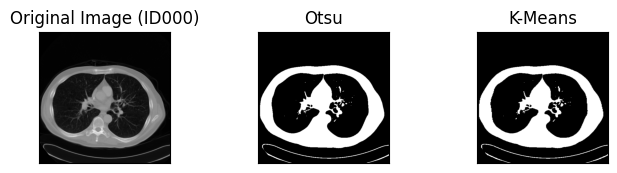

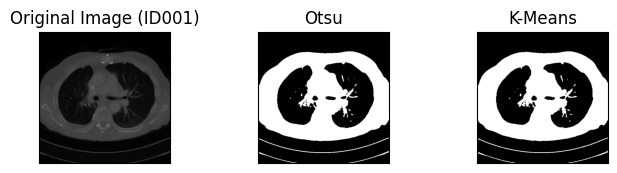

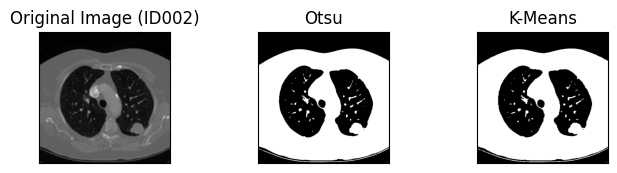

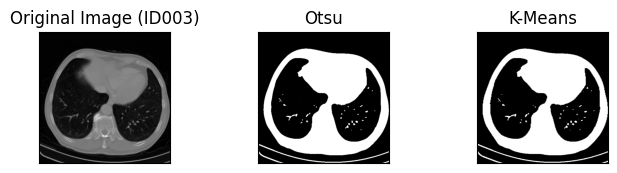

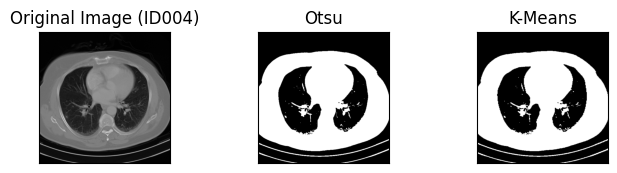

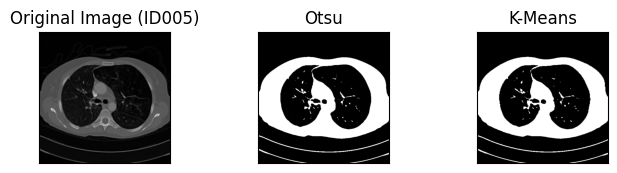

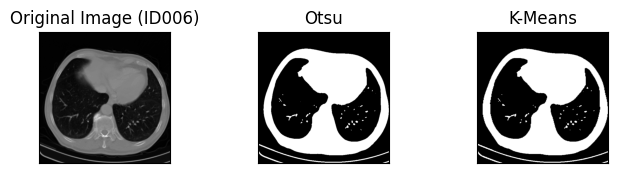

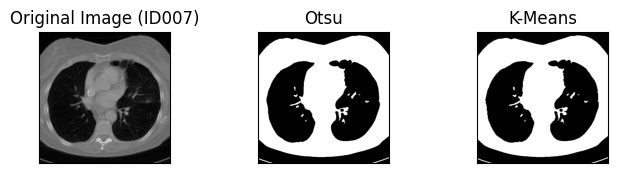

In [3]:
def kmeans_segmentation(image, num_clusters):

    pixel_values = image. reshape((-1, 2))
    pixel_values = np.float32(pixel_values)

    kmeans = KMeans(n_clusters=num_clusters, n_init = 10, random_state=42)
    kmeans.fit(pixel_values)
    
    segmented_image = kmeans.cluster_centers_[kmeans.labels_]
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image
ages = [60, 69, 74, 75, 56, 48, 75, 61]
images = []

for i, dc_image in enumerate(dcm_images):
    image = dc_image.pixel_array
    min_val = 0
    max_val = 255
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * (max_val - min_val) + min_val
    image = image.astype(np.uint8)
    _, otsu_threshold = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    min_val = 0
    max_val = 1
    kmeans = kmeans_segmentation(image, 2)
    kmeans = (kmeans - np.min(kmeans)) / (np.max(kmeans) - np.min(kmeans)) * (max_val - min_val) + min_val
    images.append({'image' : image, 'age' : ages[i], 'otsu' : otsu_threshold, 'kmeans' : kmeans})

image_number = 3

for i, img_dict in enumerate(images):
    plt.figure(figsize=(8, 16))
    plt.subplot(8, 3, i*3 + 1)
    plt.imshow(img_dict['image'], cmap='gray')
    plt.title(f'Original Image (ID00{i})')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(8, 3, i*3 + 2)
    plt.imshow(img_dict['otsu'], cmap='gray')
    plt.title('Otsu')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(8, 3, i*3 + 3)
    plt.imshow(img_dict['kmeans'], cmap='gray')
    plt.title('K-Means')
    plt.xticks([])
    plt.yticks([])
    print()

# 3-Segmentation Assessment

In [4]:
for i, seg in enumerate(images): 
    for j, seg in enumerate(images):
        if i < j:
            print(f"Metrics for ID00{i} and ID00{j}:")
            iou = segmentation_assessment.calculate_iou(seg['otsu'], seg['kmeans'])
            print("\tIOU Score:", str(iou)[:7])

            dice = segmentation_assessment.dice_coefficient(seg['otsu'], seg['kmeans'])
            print("\tDICE Score:", str(dice)[:7])

            precision, recall, f1_score, accuracy, specificity = segmentation_assessment.calculate_metrics(seg['otsu'], seg['kmeans'])
            print("\tAccuracy: ", str(accuracy)[:7])
            print()

Metrics for ID000 and ID001:
	IOU Score: 0.55862
	DICE Score: 0.99346
	Accuracy:  0.99489

Metrics for ID000 and ID002:
	IOU Score: 0.71553
	DICE Score: 0.99563
	Accuracy:  0.99510

Metrics for ID000 and ID003:
	IOU Score: 0.53005
	DICE Score: 0.99255
	Accuracy:  0.99458

Metrics for ID000 and ID004:
	IOU Score: 0.65030
	DICE Score: 0.99359
	Accuracy:  0.99377

Metrics for ID000 and ID005:
	IOU Score: 0.45504
	DICE Score: 0.99130
	Accuracy:  0.99483

Metrics for ID000 and ID006:
	IOU Score: 0.53005
	DICE Score: 0.99255
	Accuracy:  0.99458

Metrics for ID000 and ID007:
	IOU Score: 0.68686
	DICE Score: 0.99598
	Accuracy:  0.99578

Metrics for ID001 and ID002:
	IOU Score: 0.71553
	DICE Score: 0.99563
	Accuracy:  0.99510

Metrics for ID001 and ID003:
	IOU Score: 0.53005
	DICE Score: 0.99255
	Accuracy:  0.99458

Metrics for ID001 and ID004:
	IOU Score: 0.65030
	DICE Score: 0.99359
	Accuracy:  0.99377

Metrics for ID001 and ID005:
	IOU Score: 0.45504
	DICE Score: 0.99130
	Accuracy:  0.99483


# 4-Lung Region Extraction

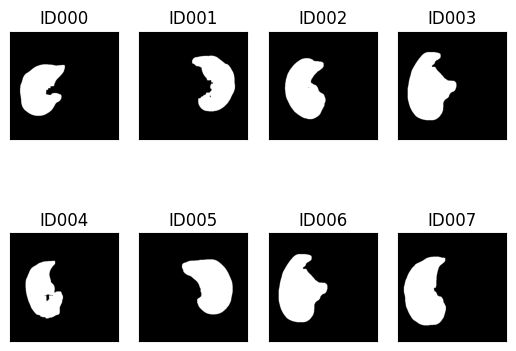

In [10]:
for i, img_dict in enumerate(images):
    _, otsu_threshold = cv2.threshold(img_dict['image'], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    otsu_threshold = cv2.bitwise_not(otsu_threshold)
    erosion = cv2.erode(otsu_threshold, np.ones((3,3), np.uint8), iterations = 1)
    predicted_mask = cv2.medianBlur(erosion, 7)
    labeled_image = measure.label(erosion)
    region_properties = measure.regionprops(labeled_image)
    sorted_regions = sorted(region_properties, key = lambda x : x.area, reverse = True)
    x = 0
    max_area = sorted_regions[x]
    while (predicted_mask.shape[0] - 10 < max_area.major_axis_length):
        x+=1
        max_area = sorted_regions[x]
    max_region = np.zeros_like(predicted_mask, dtype = np.uint8)
    max_region[labeled_image == max_area.label] = 1
    dilation = cv2.dilate(max_region, np.ones((7,7), np.uint8), iterations = 2)
    
    
    images[i]['max_region'] = dilation.copy()

for i, _ in enumerate(images):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i]['max_region'], cmap='gray'), plt.title(f"ID00{i}")
    plt.xticks([])
    plt.yticks([])
    

# 5-Shape Feature Extraction

In [6]:
for i, img_dict in enumerate(images): 
    labeled_mask = measure.label(img_dict['max_region'])
    region_properties = measure.regionprops(img_dict['max_region'])

    props = region_properties[0]
    area = props.area
    perimeter = props.perimeter
    solidity = props.solidity
    eccentricity = props.eccentricity
    major_axis_length = props.major_axis_length
    minor_axis_length = props.minor_axis_length
    orientation = props.orientation
    centroid = props.centroid
    compactness = (perimeter**2)/area
    circularity = (4*np.pi*area)/ (perimeter**2)
    elongation = major_axis_length/minor_axis_length
    aspect_ratio = major_axis_length/minor_axis_length
    extent = area/props.bbox_area
    rectangularity = area/props.bbox_area
    
    images[i]['features'] = [
        area, 
        perimeter, 
        solidity, 
        eccentricity, 
        major_axis_length, 
        minor_axis_length, 
        orientation,
        compactness,
        circularity,
        elongation,
        aspect_ratio,
        extent,
        rectangularity
    ]
    
    print(f"Metrics for ID00{i}:")
    print("\tArea:", area)
    print("\tPerimeter:", perimeter)
    print("\tSolidity:", solidity)
    print("\tEccentricity:", eccentricity)
    print("\tMajor Axis Length:", major_axis_length)
    print("\tMinor Axis Length:", minor_axis_length)
    print("\tOrientation:", orientation)
    print("\tCentroid:", centroid)
    print("\tCompactness:", compactness)
    print("\tCircularity:", circularity)
    print("\tElongation:", elongation)
    print("\tAspect Ratio:", aspect_ratio)
    print("\tExtent:", extent)
    print("\tRectangularity:", rectangularity)
    print()

Metrics for ID000:
	Area: 36279.0
	Perimeter: 916.3229432149742
	Solidity: 0.8799388779742414
	Eccentricity: 0.7250285144142968
	Major Axis Length: 272.71314615229807
	Minor Axis Length: 187.82268418820092
	Orientation: -0.3582657084882562
	Centroid: (275.69219107472645, 143.5073182833044)
	Compactness: 23.144180828086572
	Circularity: 0.5429602675377164
	Elongation: 1.4519712958581494
	Aspect Ratio: 1.4519712958581494
	Extent: 0.7013416331580575
	Rectangularity: 0.7013416331580575

Metrics for ID001:
	Area: 33326.0
	Perimeter: 948.2640687119285
	Solidity: 0.7943651228755989
	Eccentricity: 0.7998335974702224
	Major Axis Length: 297.4543610124854
	Minor Axis Length: 178.53859375956375
	Orientation: 0.12697110494462274
	Centroid: (244.62959851167255, 364.32734201524335)
	Compactness: 26.98207837754609
	Circularity: 0.4657302687555988
	Elongation: 1.66605076666541
	Aspect Ratio: 1.66605076666541
	Extent: 0.6218465442603374
	Rectangularity: 0.6218465442603374

Metrics for ID002:
	Area: 394

# 6-SVM Classifier Design

In [7]:
X = []
y = []
for img_dict in images:
    X.append(img_dict['features'])
    y.append(1 if img_dict['age'] > 60 else 0)
    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X)
faccuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {faccuracy}")

Accuracy: 0.875
